## pip

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [3]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00


## Import

In [4]:
import os
import re
import time
import json
import random
import string
import psutil
import pickle
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders, processors
import tiktoken

import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset, DataLoader

## tokenize

In [5]:
dataset=load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [6]:
tokenizer=tiktoken.get_encoding("gpt2")
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_train_samples.append(np.array(input_ids))

Tokenizing Train Set: 100%|██████████| 2119719/2119719 [05:33<00:00, 6363.82it/s]


In [7]:
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing validation Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_valid_samples.append(np.array(input_ids))

Tokenizing validation Set: 100%|██████████| 21990/21990 [00:04<00:00, 5495.16it/s]


In [8]:
tokenized_valid_samples[:1]

[array([32565,    13, 15899,  2497,   262, 22441,  1097,   290,   531,
           11,   366, 22017,    11, 21168,    11,   534,  1097,   318,
          523,  6016,   290,  3424,  2474, 21168, 13541,   290,  8712,
           11,   366, 10449,   345,    11, 15899,    13,   314, 25245,
          340,   790,  1110,   526,   198,   198,  3260,  2712,   351,
          262,  1097,    11, 21168,   290, 15899,  2936, 47124,    13,
         1119,  1043,   257,  1402, 16723,   351,  1598,  1660,    13,
         1119, 24070,   262,  1660,   290,  2936,   845,  3772,    13,
         1119,  2826,  1978,   477,  1110,   290,  2627,  1266,  2460,
           13])]

In [9]:
sumtoks=  sum(len(tok) for tok in tokenized_train_samples)
print(sumtoks)

471872517


## Save and Read Tokens

In [10]:
# Save tokens as a pickle file
with open('tokenized_train_samples.pkl', 'wb') as f:
    pickle.dump(tokenized_train_samples, f)

with open('tokenized_valid_samples.pkl', 'wb') as f:
    pickle.dump(tokenized_valid_samples, f)

In [12]:
# Load data from the pickle file
with open('tokenized_train_samples.pkl', 'rb') as f:
    tokenized_train_samples = pickle.load(f)

with open('tokenized_valid_samples.pkl', 'rb') as f:
    tokenized_valid_samples = pickle.load(f)

In [32]:
token_count_stories=[]
for tokns in tokenized_train_samples:
    token_count_stories.append(len(tokns))

In [36]:
token_count_stories_np=np.array(token_count_stories)

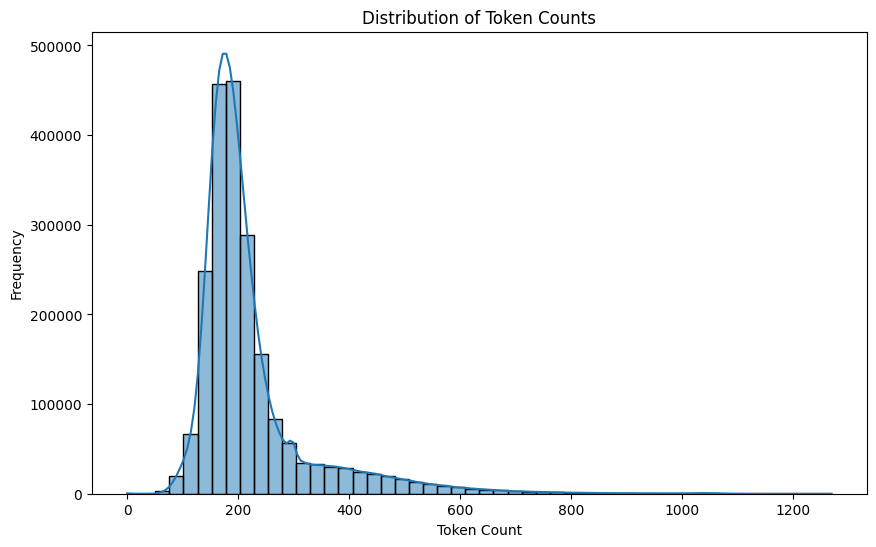

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(token_count_stories_np, bins=50, kde=True)
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts')
plt.show()